<div align=right>
LAP 3 / EMLCT Computational Morphology<br>
M. Ribalta i Albado<br>
Fall 2023
</div>

<h1 align=center>Neural Morphological Generators in Catalan and German</h1>


In this exercise we create training, validation and test data for a morphological generator with the Transformer. Then, we train different models with different datasets and analyze the results and impact. We have done this in two languages and compared them.

$ $

* All data has been gathered from the [Unimorph](https://unimorph.github.io/) website.

* The two languages have been:
  * **Catalan**, the native language of the author of this notebook. This dataset **only contains verbs**.
  * **German**, which the author has basic notions of. This dataset is a bit more complex since it contains **verbs and adjectives**.

* For each language, 3 datasets have been created using three strategies, for brevity we will be referring to them as:
  * `random`: the samples populating training, validation and test have been chosen randomly.
  * `no_overlap`: the samples populating training and validation are different from the test ones. The stems used in test have never been seen during the training step.
  * `fake_copy`: same as the previous one. However, the training samples include the stems from the test set with a "mock" inflection. This inflection is `COPY` and the source and target words are the same (e.g. source is `walk # COPY` and target is `walk`).
* Since Datasets were of different sizes, we have chosen training, validation and test size according to proportions rather than strict numbers.
  * Training represents 70% of the data.
  * Validation represents 10% of the data.
  * Test represents 20% of the data.
* To train, we have used Transformers available in the library of [fairseq](https://github.com/facebookresearch/fairseq) from Facebook Research.


$ $

Below, it is shown the table of contents:

>[Reproducibility constraints](#scrollTo=c8b91EYl4eY9)

>[🛠 Imports, functions and set up](#scrollTo=V0d7WFr6xF3F)

>[🐉🌹 Catalan Neural Morphological Generator](#scrollTo=FZn8v9xyXlbX)

>>[Preprocessing](#scrollTo=ldQLAZ5twqJV)

>>>[EDA](#scrollTo=yenoYOuMuHBV)

>>[Tokenization](#scrollTo=eCd9SRY9ekUw)

>>>[Random](#scrollTo=5R9Amk20Sogu)

>>>[No overlap](#scrollTo=77BP2ucIf-Db)

>>>[Fake Copy](#scrollTo=xuBj13WUt2Xi)

>>[Training](#scrollTo=6NhE9JKCYopt)

>>>[Random](#scrollTo=hOYXsQivAAWW)

>>>[No overlap](#scrollTo=FlOFXpu3gDlP)

>>>[Fake copy](#scrollTo=yJHwb_PfAJpH)

>>[Evaluation](#scrollTo=y51WWydWAVX4)

>>[Conclusions, improvements and future work](#scrollTo=izHY71n9QvIw)

>[🇩🇪 German Neural Morphological Generator](#scrollTo=GlUiV9vfpNP0)

>>[Preprocessing](#scrollTo=dwww3CJnupmq)

>>>[EDA](#scrollTo=snbk9s4musT1)

>>[Tokenization](#scrollTo=7gTRMW2Rrx91)

>>>[Random](#scrollTo=dHg75H3Vu0Oo)

>>>[No overlap](#scrollTo=7yTXnHN3u2RW)

>>>[Fake copy](#scrollTo=kbKfbBcPu4lh)

>>[Training](#scrollTo=3PPhOvsRsxIa)

>>>[Random](#scrollTo=3PPhOvsRsxIa)

>>>[No overlap](#scrollTo=ciu-M6-dv5XI)

>>>[Fake copy](#scrollTo=JZRXl3Nvv21K)

>>[Evaluation](#scrollTo=bR15htWkEmu1)

>>[Conclusions, improvements and future work](#scrollTo=BciHvtvc4Kb2)

>[General Conclusions](#scrollTo=6U2ZofN8O8io)



Before starting...

# Reproducibility constraints

If you desire to reproduce step by step all this notebook you need to:

* Allow this collab to acces Google Drive when asked in the following section.
* Be aware that many cells (specially in the training section) take a bit long to execute, GPU usage is highly recommended in this case. Because of it, it is recommended to simply look at the output of the cells without executing them.
* Some cells in this report read or execute from files external to this collab. These have been linked in the handover of the project. (e.g. the preprocess, training and test scripts, the input data, the datasets with the results of the test data after evaluated, etc)

# 🛠 Libraries, functions and set up

For better readibility of the analysis, some of the functions have been encapsulated inside this section.

Feel free to simply execute this group of cells without expanding this section by clicking on the play button at the left corner below. Alternatively, you can also read the different methods implemented for this analysis and execute it one by one.

In [ ]:
# Here, we mount Google drive so that Colab can access files in your Google drive.
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/morphology_project
!ls -al

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/morphology_project
total 122142
drwx------ 2 root root     4096 Dec 31 15:38 cat
-rw------- 1 root root  2902458 Dec 31 10:15 cat.txt
drwx------ 2 root root     4096 Dec 31 16:09 checkpoints
drwx------ 2 root root     4096 Dec 31 18:06 data-bin
-rw------- 1 root root 18932560 Jan  1 15:32 deu.txt
-rw------- 1 root root   279074 Jan  1 14:42 devel.cat.fake_copy.input
-rw------- 1 root root   150496 Jan  1 14:42 devel.cat.fake_copy.output
-rw------- 1 root root   279074 Jan  1 14:42 devel.cat.no_overlap.input
-rw------- 1 root root   150496 Jan  1 14:42 devel.cat.no_overlap.output
-rw------- 1 root root   280154 Jan  1 14:42 devel.cat.random.input
-rw------- 1 root root   152400 Jan  1 14:42 devel.cat.random.output
-rw------- 1 root root  1870504 Jan  1 17:01 devel.deu.fake_copy.input
-rw------- 1 root root  1114724 Jan  1 17:01 devel.d

In [ ]:
# Preprocessing and EDA
from collections import Counter
import matplotlib.pyplot as plt

# Dataset Splits
import random

# Dataset Evaluation
import pandas as pd
from sklearn.metrics import accuracy_score
from IPython.display import display_html
from itertools import chain,cycle

In [ ]:
!pip install fairseq
!pip install tensorboardX

In [ ]:
def completely_random_splits(data: list):
  # randomize
  random.seed(42) # Set a random seed so we always get the same (reproducible) order
  tokens = data.copy()
  random.shuffle(tokens)

  # split into datasets
  length = len(tokens)
  train_idx = int(length*0.8)
  devel_idx = int(length*0.9)

  train = tokens[:train_idx]
  devel = tokens[train_idx:devel_idx]
  test = tokens[devel_idx:]

  return train, devel, test

In [ ]:
def no_overlap_splits(data):
  # randomize lemmas
  random.seed(42)
  tokens = data.copy()

  lemmas = list(set([item[0].split('#')[0] for item in tokens]))
  random.shuffle(lemmas)

  # split lemmas into datasets, no overlap
  length = len(lemmas)
  train_idx = int(length*0.8)
  devel_idx = int(length*0.9)

  train_lemmas = lemmas[:train_idx]
  devel_lemmas = lemmas[train_idx:devel_idx]
  test_lemmas = lemmas[devel_idx:]

  # take each sample from each lemma and add it to the corresponding dataset
  train, devel, test = [], [], []
  for sample in tokens:
    lemma = sample[0].split('#')[0]
    if lemma in train_lemmas:
      train.append(sample)
    elif lemma in devel_lemmas:
      devel.append(sample)
    else:
      test.append(sample)

  return train, devel, test, test_lemmas # we will use test_lemmas in the next section

In [ ]:
def fake_copy_splits(data):
  # no overlap samples
  train, devel, test, test_lemmas = no_overlap_splits(tokenized)

  # add samples from test in fake-copy mode in train
  for test_lemma in test_lemmas:
    train.append((f'{test_lemma}# COPY', test_lemma))

  # shuffle train again
  random.shuffle(train)

  return train, devel, test

In [ ]:
def save_to_file(file, filename):
  with open(filename, 'w') as fp:
    for item in file:
        # write each item on a new line
        fp.write("%s\n" % item)

In [ ]:
def save_input_output_files(data: list, language:str, split_mode: str, dataset_type: str):
  input = [sample[0] for sample in data]
  output = [sample[1] for sample in data]

# devel cat random output
  save_to_file(input, f'{dataset_type}.{language}.{split_mode}.input')
  save_to_file(output, f'{dataset_type}.{language}.{split_mode}.output')

In [ ]:
def create_results_table(filename: str) -> pd.DataFrame:
    S, T, D = [], [], []
    with open(f"results/{filename}","r") as fi:
        for ln in fi:
            ln = ln.replace('\t', ' @ ').replace('\n', '')
            if ln.startswith("S-"):
                S.append(ln[2:])
            elif ln.startswith("T-"):
                T.append(ln[2:])
            elif ln.startswith("D-"):
                D.append(ln[2:])
            else:
                pass

    df_s = pd.DataFrame(S)
    df_s[['idx', 'source_s']] = df_s[0].str.split('@', expand=True)
    df_s = df_s.drop(columns=0).set_index('idx')

    df_t = pd.DataFrame(T)
    df_t[['idx', 'target']] = df_t[0].str.split('@', expand=True)
    df_t = df_t.drop(columns=0).set_index('idx')

    df_d = pd.DataFrame(D)
    df_d[['idx', 'score_d', 'predicted']] = df_d[0].str.split('@', expand=True)
    df_d = df_d.drop(columns=0).set_index('idx')

    df = pd.concat([df_s, df_t, df_d], axis=1, join="inner")
    df['lemma'] = df['source_s'].map(lambda row: row.split('#')[0]) # add the original lemma of the verb for analytic purposes

    return df[['lemma','source_s','target','predicted']]

In [ ]:
def get_verb_ending_results(results_df: pd.DataFrame) -> pd.DataFrame:
    results_df['verb_ending'] = results_df.lemma.map(lambda verb: verb[-4:])
    results_df['correct'] = results_df.target == results_df.predicted
    results_df['counts'] = 1
    return results_df[['verb_ending', 'correct', 'counts']].groupby(['verb_ending', 'correct']).count().reset_index()

def plot_verb_ending_correctness(results_df: pd.DataFrame):
  verb_ending_df = get_verb_ending_results(results_df)

  fig, (ax1, ax2) = plt.subplots(2, 1)
  fig.suptitle('Verb Ending Correctness')
  ax1.bar(
      verb_ending_df[verb_ending_df.correct == True].verb_ending,
      verb_ending_df[verb_ending_df.correct == True].counts,
  )
  ax1.set(ylabel='Correct Predictions')
  ax2.bar(
      verb_ending_df[verb_ending_df.correct == False].verb_ending,
      verb_ending_df[verb_ending_df.correct == False].counts,
      color='orange'
  )
  ax2.set(xlabel='Verb Ending', ylabel='Wrong Predictions')
  fig.show()

In [ ]:
def get_grammatical_category(morph_tag: str) -> str:
  # we expect to receive something like: 'J a r # N NOM NEUT SG'
  morph_tag = morph_tag.split('#')[1]
  return morph_tag.split(' ')[1]


def get_grammatical_category_results(results_df: pd.DataFrame) -> pd.DataFrame:
    results_df['grammatical_category'] = results_df.source_s.map(get_grammatical_category)
    results_df['correct'] = results_df.target == results_df.predicted
    results_df['counts'] = 1
    return results_df[['grammatical_category', 'correct', 'counts']].groupby(['grammatical_category', 'correct']).count().reset_index()

def plot_grammatical_category_correctness(results_df: pd.DataFrame):
  grammatical_cat_df = get_grammatical_category_results(results_df)

  fig, (ax1, ax2) = plt.subplots(2, 1)

  fig.suptitle(f'Grammatical Category Correctness')
  ax1.bar(
      grammatical_cat_df[grammatical_cat_df.correct == True].grammatical_category,
      grammatical_cat_df[grammatical_cat_df.correct == True].counts,
  )
  ax1.set(ylabel='Correct Predictions')
  ax2.bar(
      grammatical_cat_df[grammatical_cat_df.correct == False].grammatical_category,
      grammatical_cat_df[grammatical_cat_df.correct == False].counts,
      color='orange'
  )
  ax2.set(xlabel='Grammatical Category Correctness', ylabel='Wrong Predictions')
  fig.show()

In [ ]:
def get_case(morph_tags: str) -> str:
  morph_tags = morph_tags.split('#')[1]
  return morph_tags.split(' ')[2]

def get_gender(morph_tags: str) -> str:
  morph_tags = morph_tags.split('#')[1]
  gender = morph_tags.split(' ')[3]
  if gender == 'PL' or gender == 'SG':
    return 'NA'
  return gender

def get_number(morph_tags: str) -> str:
  morph_tags = morph_tags.split('#')[1]

  try:
    number = morph_tags.split(' ')[4]
  except:
    number = morph_tags.split(' ')[3]
    if not ((number == 'SG') or (number == 'PL')):
      number = 'NA'

  return number

In [ ]:
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)


# 🐉🌹 Catalan Neural Morphological Generator

* Data used can be downloaded here: https://github.com/unimorph/cat
* This dataset contains 81576 samples, formed by a total of 1547 different stems.
* In this case, we only have verbs derived to different tenses (in Catalan there are several ways of referring to the past, present and future, as well as subjunctive, imperative and infinitive forms).
* Catalan can also have different morphemes depending on the gender of the subject.
* It is mostly a non-agglutinative language (unlike German) so there are no great variations or exceptions when applying a tense to a verb.

## Preprocessing

### EDA

We will first read the files downloaded from Unimorph and adapt the format that the neural network expects:

In [ ]:
examples = [l.strip() for l in open("cat.txt") if len(l) > 1]
examples = [s.replace(' ', '_') for s in examples] # Can't use spaces as tokens, so replace those

Let's take a look at some examples of the dataset, we will also take a look to how many inflections most repeated verbs have and the least ones:

In [ ]:
counter = Counter()

for example in examples:
  counter[example.split('\t')[0]] += 1

In [ ]:
counter.most_common(10)

[('abaixar', 53),
 ('abandonar', 53),
 ('abatre', 53),
 ('abdicar', 53),
 ('abeurar', 53),
 ('abolir', 53),
 ('abominar', 53),
 ('abraçar', 53),
 ('abrandar', 53),
 ('abreujar', 53)]

In [ ]:
counter.most_common()[-10:]

[('transmetre', 50),
 ('traure', 50),
 ('treure', 50),
 ('vendre', 50),
 ("veure's", 50),
 ('veure', 50),
 ('viure', 50),
 ('haver', 45),
 ('dar', 39),
 ('caldre', 17)]

In [ ]:
nr_of_verbs_w_samples = Counter(counts for verb, counts in counter.most_common())
print(nr_of_verbs_w_samples)

Counter({53: 1425, 50: 119, 45: 1, 39: 1, 17: 1})


* Most of our verb stems (1425) have 53 derivations assigned to a same root.
* 119 stems have only 50 derived versions of it.

* "Haver" (an auxiliary similar to "there is") has "only" 45 derived forms. This verb is constantly used due to its auxiliary nature, however its structure is quite similar and repeated in most tenses. This is probably why there are less samples of it.
* "Dar" (to give) has only 39 derived forms. As a curiosity, it is not a very common (or used) verb nowadays and mostly known by elderly people. Currently, the most popular version of it is the verb "donar" (to give, as well).
* "Caldre" (similar to "need") has only 17 derived forms in the dataset. This verb is mostly used in an impersonal manner "cal comprar menjar" ("there's the need to buy food").

Since the data is originally from Wikipedia, it is not rare that these verbs have less derived forms since they are less used in specific tenses and by the Catalan people. At the end of the day, our data tends to be the reflection of society's usage of it, in this case, the usage of verbs.


Let's now take a look at verb endings. It is interesting to note that verbs in Catalan can finish in -ar, -er, -re or -ir. However, this list also includes reflexive versions of the verbs, see: "veure" (to see) and "veure's" (to see oneself). It might be interesting to check later in the evaluation step if the model has been able to infer correctly these specific formats of the verbs, since verb endings have, usually, information about what structure should we follow when deriving a verb.

In [ ]:
verb_endings = Counter()
for verb in counter.keys():
  verb_ending = verb[-2:]
  verb_endings[verb_ending] += 1

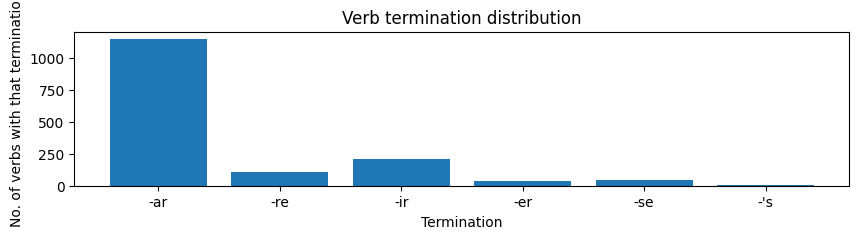

In [ ]:
fig = plt.figure(figsize = (10, 2))
plt.bar([f"-{ter}" for ter in verb_endings.keys()], verb_endings.values())

plt.xlabel("Termination")
plt.ylabel("No. of verbs with that termination")
plt.title("Verb termination distribution")
plt.show()

We can see that there is a great imbalance between verb terminations. This might affect the results of our neural morphological generator, probably being biased towards word forms present in "-ar" verbs. It is probably also that reflexive verbs ("-se", "-'s")

Now that we have taken a look at our data, let's tokenize and prepare it for training!

In [ ]:
tokenized = []
for ex in examples:
    lemma, inflection, tags = ex.split('\t')
    tagtokens = tags.split(';')
    tokenized.append((' '.join(list(lemma)) + " # " + ' '.join(tagtokens),\
                      ' '.join(list(inflection))))

tokenized[:10]

[('a b a i x a r # V.PTCP PST SG FEM', 'a b a i x a d a'),
 ('a b a i x a r # V.PTCP PST PL FEM', 'a b a i x a d e s'),
 ('a b a i x a r # V.PTCP PRS', 'a b a i x a n t'),
 ('a b a i x a r # V IND FUT 3 PL', 'a b a i x a r a n'),
 ('a b a i x a r # V IND FUT 2 SG', 'a b a i x a r à s'),
 ('a b a i x a r # V IND FUT 3 SG', 'a b a i x a r à'),
 ('a b a i x a r # V IND FUT 1 PL', 'a b a i x a r e m'),
 ('a b a i x a r # V IND PST 1 PL PFV', 'a b a i x à r e m'),
 ('a b a i x a r # V IND PST 3 PL PFV', 'a b a i x a r e n'),
 ('a b a i x a r # V IND PST 2 SG PFV', 'a b a i x a r e s')]

## Tokenization

We want to have data in 2-tuples `tokenized` that look like this:
[(input string 1, output string 1), (input string 2, output string 2, ...)]

Remember that in this step we will randomize in three different ways:

1. Completely random.
2. No lemma overlap between train and test.
3. No lemma overlap and fake copy examples.


### Random

In [ ]:
random_train, random_devel, random_test = completely_random_splits(tokenized)

In [ ]:
print(len(random_train), len(random_devel), len(random_test))

65260 8158 8158


### No overlap

In [ ]:
no_overlap_train, no_overlap_devel, no_overlap_test, test_lemmas = no_overlap_splits(tokenized)

In [ ]:
no_overlap_train[:10]

[('a b a i x a r # V.PTCP PST SG FEM', 'a b a i x a d a'),
 ('a b a i x a r # V.PTCP PST PL FEM', 'a b a i x a d e s'),
 ('a b a i x a r # V.PTCP PRS', 'a b a i x a n t'),
 ('a b a i x a r # V IND FUT 3 PL', 'a b a i x a r a n'),
 ('a b a i x a r # V IND FUT 2 SG', 'a b a i x a r à s'),
 ('a b a i x a r # V IND FUT 3 SG', 'a b a i x a r à'),
 ('a b a i x a r # V IND FUT 1 PL', 'a b a i x a r e m'),
 ('a b a i x a r # V IND PST 1 PL PFV', 'a b a i x à r e m'),
 ('a b a i x a r # V IND PST 3 PL PFV', 'a b a i x a r e n'),
 ('a b a i x a r # V IND PST 2 SG PFV', 'a b a i x a r e s')]

### Fake Copy

In [ ]:
fake_copy_train, fake_copy_devel, fake_copy_test = fake_copy_splits(tokenized)

In [ ]:
for i in range(len(fake_copy_train)):
  if fake_copy_train[i][0].split('#')[1] == ' COPY':
    idx = i
    break

In [ ]:
fake_copy_train[idx]

('a b r a ç a r # COPY', 'a b r a ç a r ')

Now we have everything we need. We will store our datasets into files. We will name the files following this style:

`{language}.{split_mode}.{dataset_type}.{input_or_output}`

Language can be:
* `cat` for Catalan.
* `deu` for German.

Split mode is:
* `random` for random split.
* `no_overlap`, for no overlap split.
* `fake_copy`, for no overlap split but fake copy samples in train.

Dataset type:
* `train` for training samples.
* `devel` for validation samples.
* `test` for test samples.

Input or output:
* `input` for the homonymous.
* `output` for the homonymous.

In [ ]:
save_input_output_files(random_train, 'cat', 'random', 'train')
save_input_output_files(random_devel, 'cat', 'random', 'devel')
save_input_output_files(random_test, 'cat', 'random', 'test')

save_input_output_files(no_overlap_train, 'cat', 'no_overlap', 'train')
save_input_output_files(no_overlap_devel, 'cat', 'no_overlap', 'devel')
save_input_output_files(no_overlap_test, 'cat', 'no_overlap', 'test')

save_input_output_files(fake_copy_train, 'cat', 'fake_copy', 'train')
save_input_output_files(fake_copy_devel, 'cat', 'fake_copy', 'devel')
save_input_output_files(fake_copy_test, 'cat', 'fake_copy', 'test')

## Training

### Random


In [ ]:
!bash ./preprocess.sh cat random

In [ ]:
!bash ./train.sh cat random

In [ ]:
#!chmod 777 test.sh
!./test.sh cat random

### No overlap

In [ ]:
# interesting to see that in devel and test we have <unk> tokens
!bash ./preprocess.sh cat no_overlap

In [ ]:
!rm -r checkpoints/cat-models/
!bash ./train.sh cat no_overlap

2024-01-02 14:17:15.079318: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-02 14:17:15.079378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-02 14:17:15.100275: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-02 14:17:15.143133: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-02 14:17:19.231896: W tensorflow/comp

In [ ]:
!chmod 777 test.sh
!./test.sh cat no_overlap

2024-01-02 15:04:44.438393: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-02 15:04:44.438441: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-02 15:04:44.439927: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-02 15:04:44.447792: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-02 15:04:45.436032: W tensorflow/comp

### Fake copy

In [ ]:
!bash ./preprocess.sh cat fake_copy

2024-01-01 15:10:38.323570: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-01 15:10:38.323641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-01 15:10:38.325670: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-01 15:10:38.337663: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-01 15:10:39.831151: W tensorflow/compiler/tf2

In [ ]:
!rm -r checkpoints/cat-models/
!bash ./train.sh cat fake_copy

2024-01-01 15:11:10.199697: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-01 15:11:10.199754: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-01 15:11:10.201577: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-01 15:11:10.211941: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-01 15:11:12.194099: W tensorflow/compiler/tf2

In [ ]:
!./test.sh cat fake_copy

2024-01-01 15:26:20.699481: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-01 15:26:20.699531: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-01 15:26:20.700860: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-01 15:26:20.708118: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-01 15:26:21.776284: W tensorflow/compiler/tf2

## Evaluation

To analyze the results, we obtain for each training a file with several lines. To interpret it, we have preprocessed it before.However, in order to understand the raw data must take into account the following statements ([source](https://github.com/facebookresearch/fairseq/issues/3000)):

* **S** - Source, the input passed through the model.
* **T** - Target, the expected/ideal output. Also known as gold or reference.
* **H** - Hypothesis, the model's output without decoding. Some weird symbols can appear if we have applied a special preprocessing such as byte pair encoding.
* **D** - Decoded. The human-readable result.

We will apply a function that will transform our results into a table so that we are able to compare.

In [ ]:
results_random = create_results_table("test_cat_random_results.txt")
results_no_overlap = create_results_table("test_cat_no_overlap_results.txt")
results_fake_copy = create_results_table("test_cat_fake_copy_results.txt")

In [ ]:
results_random.head()

,lemma,source_s,target,predicted
idx,,,,
4363,u s a r,u s a r # V POS IMP 3 PL,u s i n,u s i n
1948,m o c a r,m o c a r # V.PTCP PST SG MASC,m o c a t,m o c a t
1400,d e u r e,d e u r e # V.PTCP PST SG MASC,d e g u t,d e g u t
790,f e r i r,f e r i r # V.PTCP PST SG MASC,f e r i t,f e r i t
403,r o b a r,r o b a r # V.PTCP PST SG MASC,r o b a t,r o b a t


In [ ]:
# y_true, y_pre
print(f'accuracy random: {accuracy_score(results_random.target, results_random.predicted)}')
print(f'accuracy no_overlap: {accuracy_score(results_no_overlap.target, results_no_overlap.predicted)}')
print(f'accuracy fake_copy: {accuracy_score(results_fake_copy.target, results_fake_copy.predicted)}')

accuracy random: 0.9886001470948762
accuracy no_overlap: 0.9621648095996082
accuracy fake_copy: 0.9679196767478878


**Random split**

The random split has almost a 100% of accuracy. Does this mean that the model is perfect and knows how to generalise? It does not. In fact, this kind of split is not ideal and this accuracy could be misleading.

The fact that we are using the same verbs in training and in test is actually filtering information to the model when training, so it could be considered as "cheating". This way, the model does not learn to derive the morphemes but rather learns the verb itself. Probably, if faced with a never-seen-before verb, the predictions wouldn't be accurate.

These little details are really important when deciding how to create the split of train and test, since building a model like this can lead to undesired performance.


**No overlap and Fake copy**

The remaining two models have a very good performance as well, with only 0.005 difference of accuracy performance between them. We could consider that, in this case, adding copy-fake values does not increase considerably the performance of the model.

However, let's take a look at the differences and see where they behave differently. We will take a look at the verb endings we have mentioned in the EDA step.

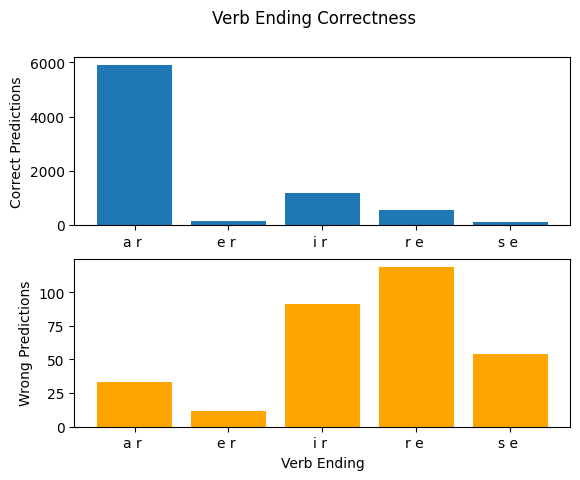

In [ ]:
plot_verb_ending_correctness(results_no_overlap)

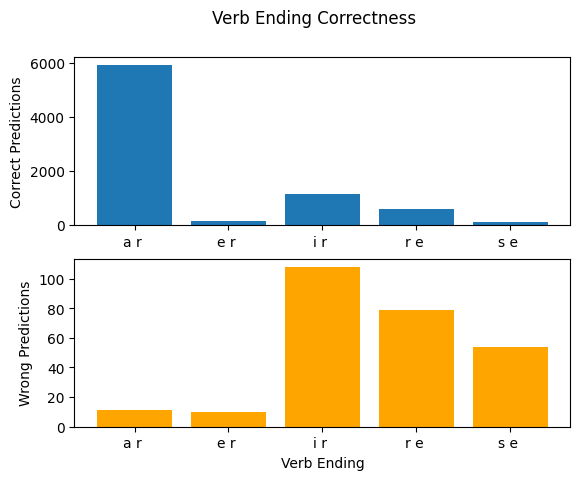

In [ ]:
plot_verb_ending_correctness(results_fake_copy)

The differences between these two models seem to rely on the wrong predictions rather than the correct ones, since the distribution of correct predictions is almost identical.

The `no_overlap` model seems to predict better -ir ending verbs but worse -re ending verbs. Whereas, on the contrary, `fake_copy` model performs slightly better on -re ending verbs but worse on -ir.

When it comes to reflexive verbs (-se ending verbs) both models seem to perform poorly. Note that there are not -'s ending verbs. Given the few samples found in the whole data, it is likely that all samples with this ending have fallen in the input, therefore it has not been possible to evaluate them in the test.

## Conclusions, improvements and future work

Given the good performance in this language, it is hard to mention possible improvements since we already got a solid model.
However, we could draw some conclusions:

* Catalan is quite a regular language when it comes to verbs, this enables neural networks to learn patterns and perform well in morphological generators.
* Further investigation could be done with reflexive verbs, since most of the verbs can be converted to reflexive using the particle `-se` or `-'s` to better asses the models capabilities with this type of lemma.
* This dataset is limited to verbs, it would be interesting to add other types of morphemes such as adjectives.
* The model is already small (can be trained under less than 10 minutes), however we could perform some experiments to see how to make the model smaller in order to be even faster.

# 🇩🇪 German Neural Morphological Generator

* Data used can be downloaded here: https://github.com/unimorph/deu

* This dataset contains 519,143 samples, formed by a total of 39,373 different stems.
* In this case, we have verbs derived to different tenses but we also find adjectives and nouns.
* It is worth mentioning that German uses declinations, meaning that words are identified given the particles that conform them and also can be derived to different cases. It is important to note that the morphology annotations here will be considerably different from Catalan.
* German, unlike Catalan, does not change words depending on the gender of the subject, we could say it is gender-neutral (except for some specific words that have gender in the nature of the meaning itself). Also, the third person in singular has an additional case: whereas in Catalan there is only the equivalent to "he":"er", "she":"sie", German has the equivalent to "it":"es".
* German is an agglutinative language, meaning that many words are formed by the combination and agglutination of other morphemes, making the grammar wide and sometimes complex. We can find very long words meaning a single thing.

## Preprocessing

In [ ]:
examples = [l.strip() for l in open("deu.txt") if len(l) > 1]
examples = [s.replace(' ', '_') for s in examples] # Can't use spaces as tokens, so replace those

### EDA

In [ ]:
counter = Counter()

for example in examples:
  counter[example.split('\t')[0]] += 1

This dataset has 39373 different stems. Quite different from before, where the number was much smaller:

In [ ]:
len(counter.keys())

39373

In [ ]:
counter.most_common(10)

[('verticken', 120),
 ('scheren', 89),
 ('auspowern', 76),
 ('übersiedeln', 75),
 ('wandern', 74),
 ('handeln', 74),
 ('wildeln', 74),
 ('krempeln', 74),
 ('flittern', 74),
 ('kollern', 74)]

In [ ]:
counter.most_common()[-10:]

[('inner', 2),
 ('warzig', 2),
 ('knalleng', 2),
 ('einheitlich', 2),
 ('genügend', 2),
 ('mutlos', 2),
 ('antigrippal', 2),
 ('erstrangig', 2),
 ('minder', 1),
 ('berlinfern', 1)]

It is interesting to see how the number of occurences vary a lot inside the same dataset.
* The most common verb, with difference, is "verticken" (to sell) with 120 different entrances.
* The second is far below, with 89 samples, "scheren" (to cut) is the second most common German verb.

As for the least common verbs, we have very few samples of some of them.
* These verbs will be interesting to look at, since they might fall only on the test dataset, in which case we would be facing a **zero-shot** case-scenarion; or fall in train and test, in which case we would be facing a **few-shot** case-scenario.
* These will be interesting to take into account in the evaluation step, since they are likely to **lower the accuracy** due to its few (or unexisting) appearances in the training set.
* On the other hand, the model might be able to generalize and predict them well if the rest of the data has helped in the inference learning process.

Regular verbs in German end in `-en`, `-ern` or `-eln`, however there are exceptions.

In [ ]:
df = pd.DataFrame(examples)
df[['stem', 'derivative', 'morphology']] = df[0].str.split('\t', expand=True)
df = df.drop(columns=[0])
df['grammatical_category'] = df['morphology'].map(lambda text: text.split(';')[0])

In this dataset we see that we have 4 different grammatical categories:
* Noun.
* Verb.
* Verb in participle.
* Adjectives.

And the distribution of samples is the following:

In [ ]:
df.grammatical_category.value_counts()

N         219104
V         198913
ADJ        87503
V.PTCP     13623
Name: grammatical_category, dtype: int64

Given the diversity of this dataset, it is likely that it performs a bit worse than our previous model. It is interesting in the evaluation step, to check which which of these categories perform better.

## Tokenization

In [ ]:
tokenized = []
for ex in examples:
    lemma, inflection, tags = ex.split('\t')
    tagtokens = tags.split(';')
    tokenized.append((' '.join(list(lemma)) + " # " + ' '.join(tagtokens),\
                      ' '.join(list(inflection))))

tokenized[:10]

[('W a s h i n g t o n # N NOM NEUT SG', 'W a s h i n g t o n'),
 ('W a s h i n g t o n # N GEN NEUT SG', 'W a s h i n g t o n s'),
 ('W a s h i n g t o n # N DAT NEUT SG', 'W a s h i n g t o n'),
 ('W a s h i n g t o n # N ACC NEUT SG', 'W a s h i n g t o n'),
 ('H i r s c h h o r n s a l z # N NOM NEUT SG',
  'H i r s c h h o r n s a l z'),
 ('H i r s c h h o r n s a l z # N GEN NEUT SG',
  'H i r s c h h o r n s a l z e s'),
 ('H i r s c h h o r n s a l z # N DAT NEUT SG',
  'H i r s c h h o r n s a l z e'),
 ('H i r s c h h o r n s a l z # N ACC NEUT SG',
  'H i r s c h h o r n s a l z'),
 ('S p a n n e r # N NOM MASC SG', 'S p a n n e r'),
 ('S p a n n e r # N NOM MASC PL', 'S p a n n e r')]

### Random

In [ ]:
deu_random_train, deu_random_devel, deu_random_test = completely_random_splits(tokenized)

In [ ]:
deu_random_train[:10]

[('E h r b a r k e i t # N DAT FEM SG', 'E h r b a r k e i t'),
 ('g ä h n e n # V IMP SG 2', 'g ä h n'),
 ('k ö n n e n # V IND SG 1 PRS', 'k a n n'),
 ('H e s s e # N DAT MASC PL', 'H e s s e n'),
 ('l o s s c h i e ß e n # V NFIN', 'l o s s c h i e ß e n'),
 ('F e r n s t u d i u m # N NOM NEUT PL', 'F e r n s t u d i e n'),
 ('n a c h s a g e n # V SBJV SG 3 PRS', 's a g e _ n a c h'),
 ('s c h r e i e n # V SBJV SG 3 PST', 's c h r i e e'),
 ('A u s z a h l u n g # N ACC FEM PL', 'A u s z a h l u n g e n'),
 ('Z o b e l # N NOM MASC PL', 'Z o b e l')]

In [ ]:
print(len(deu_random_train), len(deu_random_devel), len(deu_random_test))

415314 51914 51915


We can see that the proportions of the German dataset are much bigger than the Catalan (more than 6 times bigger!). For this reason, some of the processes might take more time than before, specially training and some preprocessing.

In [ ]:
415314/65000

6.389446153846154

### No overlap

In [ ]:
deu_no_overlap_train, deu_no_overlap_devel, deu_no_overlap_test, deu_test_lemmas = no_overlap_splits(tokenized) # this function is specially slow

In [ ]:
deu_no_overlap_test[:10]

[('S p i e l v e r d e r b e r i n # N NOM FEM SG',
  'S p i e l v e r d e r b e r i n'),
 ('S p i e l v e r d e r b e r i n # N NOM FEM PL',
  'S p i e l v e r d e r b e r i n n e n'),
 ('S p i e l v e r d e r b e r i n # N GEN FEM SG',
  'S p i e l v e r d e r b e r i n'),
 ('S p i e l v e r d e r b e r i n # N GEN FEM PL',
  'S p i e l v e r d e r b e r i n n e n'),
 ('S p i e l v e r d e r b e r i n # N DAT FEM SG',
  'S p i e l v e r d e r b e r i n'),
 ('S p i e l v e r d e r b e r i n # N DAT FEM PL',
  'S p i e l v e r d e r b e r i n n e n'),
 ('S p i e l v e r d e r b e r i n # N ACC FEM SG',
  'S p i e l v e r d e r b e r i n'),
 ('S p i e l v e r d e r b e r i n # N ACC FEM PL',
  'S p i e l v e r d e r b e r i n n e n'),
 ('S c h w e s t e r l e i n # N NOM NEUT SG', 'S c h w e s t e r l e i n'),
 ('S c h w e s t e r l e i n # N NOM NEUT PL', 'S c h w e s t e r l e i n')]

### Fake copy

In [ ]:
deu_fake_copy_train, deu_fake_copy_devel, deu_fake_copy_test = fake_copy_splits(tokenized)

In [ ]:
for i in range(len(deu_fake_copy_train)):
  if deu_fake_copy_train[i][0].split('#')[1] == ' COPY':
    idx = i
    break

print(deu_fake_copy_train[idx])

('u n t e r w ü r f i g # COPY', 'u n t e r w ü r f i g ')


Now let's save data into files, so that our model can read it and train with it.

In [ ]:
save_input_output_files(deu_random_train, 'deu', 'random', 'train')
save_input_output_files(deu_random_devel, 'deu', 'random', 'devel')
save_input_output_files(deu_random_test, 'deu', 'random', 'test')

save_input_output_files(deu_no_overlap_train, 'deu', 'no_overlap', 'train')
save_input_output_files(deu_no_overlap_devel, 'deu', 'no_overlap', 'devel')
save_input_output_files(deu_no_overlap_test, 'deu', 'no_overlap', 'test')

save_input_output_files(deu_fake_copy_train, 'deu', 'fake_copy', 'train')
save_input_output_files(deu_fake_copy_devel, 'deu', 'fake_copy', 'devel')
save_input_output_files(deu_fake_copy_test, 'deu', 'fake_copy', 'test')

## Training

### Random

In [ ]:
!bash ./preprocess.sh deu random

2024-01-01 17:01:42.564721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-01 17:01:42.564776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-01 17:01:42.566197: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-01 17:01:42.573641: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-01 17:01:43.915375: W tensorflow/compiler/tf2

In [ ]:
!rm -r checkpoints/cat-models/
!bash ./train.sh deu random

2024-01-01 17:04:25.753652: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-01 17:04:25.753725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-01 17:04:25.755894: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-01 17:04:25.768278: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-01 17:04:27.276923: W tensorflow/compiler/tf2

In [ ]:
#!chmod 777 test.sh
!./test.sh deu random

2024-01-01 17:22:39.526797: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-01 17:22:39.526855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-01 17:22:39.528283: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-01 17:22:39.536080: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-01 17:22:40.611318: W tensorflow/compiler/tf2

### No overlap

In [ ]:
!bash ./preprocess.sh deu no_overlap

2024-01-01 17:31:27.984584: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-01 17:31:27.984712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-01 17:31:27.986645: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-01 17:31:27.997301: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-01 17:31:29.555818: W tensorflow/compiler/tf2

In [ ]:
!rm -r checkpoints/deu-models/
!bash ./train.sh deu no_overlap

2024-01-01 17:38:29.228811: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-01 17:38:29.228866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-01 17:38:29.230198: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-01 17:38:29.237563: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-01 17:38:30.455744: W tensorflow/compiler/tf2

In [ ]:
#!chmod 777 test.sh
!./test.sh deu no_overlap

2024-01-01 17:53:37.256359: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-01 17:53:37.256418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-01 17:53:37.257939: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-01 17:53:37.266618: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-01 17:53:38.361665: W tensorflow/compiler/tf2

### Fake copy

In [ ]:
!bash ./preprocess.sh deu fake_copy

2024-01-01 18:00:02.440700: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-01 18:00:02.440757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-01 18:00:02.442151: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-01 18:00:02.449887: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-01 18:00:03.559426: W tensorflow/compiler/tf2

In [ ]:
!rm -r checkpoints/deu-models/
!bash ./train.sh deu fake_copy

2024-01-01 18:02:22.124687: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-01 18:02:22.124748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-01 18:02:22.126102: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-01 18:02:22.133882: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-01 18:02:23.346760: W tensorflow/compiler/tf2

In [ ]:
#!chmod 777 test.sh
!./test.sh deu fake_copy

2024-01-01 18:18:12.729701: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-01 18:18:12.729764: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-01 18:18:12.731154: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-01 18:18:12.738529: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-01 18:18:14.034955: W tensorflow/compiler/tf2

## Evaluation

In [ ]:
results_deu_random = create_results_table("test_deu_random_results.txt")
results_deu_no_overlap = create_results_table("test_deu_no_overlap_results.txt")
results_deu_fake_copy = create_results_table("test_deu_fake_copy_results.txt")

In [ ]:
# y_true, y_pre
print(f'accuracy random: {accuracy_score(results_deu_random.target, results_deu_random.predicted)}')
print(f'accuracy no_overlap: {accuracy_score(results_deu_no_overlap.target, results_deu_no_overlap.predicted)}')
print(f'accuracy fake_copy: {accuracy_score(results_deu_fake_copy.target, results_deu_fake_copy.predicted)}')

accuracy random: 0.878532216122508
accuracy no_overlap: 0.8795730228044638
accuracy fake_copy: 0.8678117418728772


Overall, these are very good results as well (even if they don't reach as much accuracy as the Catalan model, which was predictable since Catalan is quite regular and the dataset is simpler). Taking into account the higher complexity of the data (mixing nouns, verbs and adjectives) the accuracy is quite good (almost reaching 90%). We can also be sure that the great amount of data populating the dataset benefits the learning process of the model.

It is curious to see that the German model, even if "cheating" (`random` model that has information of the test in the training step) achieves a similar (even slightly lower) performance that the other two models (`no_overlap` and `fake_copy`).

Let's take a look at where those models fail.

We will first take a look at some mistakes our best model has done:

In [ ]:
results_deu_no_overlap[results_deu_no_overlap.target != results_deu_no_overlap.predicted].sample(15)

,lemma,source_s,target,predicted
idx,,,,
36925,k a r t o g r a p h i e r e n,k a r t o g r a p h i e r e n # V SBJV SG 1 PRS,k a r t o g r a p h i e r e,r a p h i e r e _ k a r t o g
41886,ü b e r z i e h e n,ü b e r z i e h e n # V IND PL 3 PRS,z i e h e n _ ü b e r,ü b e r z i e h e n
36294,e r d r o s s e l n,e r d r o s s e l n # V IMP SG 2,e r d r o s s l e,e r d r o s s e l
14185,R e v o l v e r h e l d,R e v o l v e r h e l d # N GEN MASC PL,R e v o l v e r h e l d e n,R e v o l v e r h e l d e
35682,k n i s t e r n,k n i s t e r n # V SBJV SG 1 PRS,k n i s t r e,k n i s t e r e
29825,m i t e s s e n,m i t e s s e n # V IMP SG 2,e s s,e s s e _ m i t
16669,T a g e s b e g i n n,T a g e s b e g i n n # N GEN MASC SG,T a g e s b e g i n n s,T a g e s b e g i n n e s
30363,u m g e h e n,u m g e h e n # V SBJV SG 2 PRS,u m g e h e s t,g e h e s t _ u m
1505,Z a h n p a s t a,Z a h n p a s t a # N ACC FEM PL,Z a h n p a s t a e n,Z a h n p a s t a s


How interesting!
We can see that some mistakes that could have been common are:
* **Ortography mistakes**: Albatrosse and	Albatröse are almost identical but there is one missing `s` and the "umlaüt" symbol (¨) in the o.
* **Afix positioning**: we observe several underscores (_) which show the need of locating other words in between, as we have said German is an agglutinative language and structures can become complex very quickly.
* **Letter swaps**: "sichern" has been derived as "sichre" when it should be "sicher". This phenomena is quite common when it comes to `-re` particles, but our model has not been able to infer this.
* There are other mistakes that the model clearly predicted incorrectly, such as the last sample shown "Trilemmata" and "Trilemmas"

* Note, also, that this model deals with **lowercase and uppercase**. This could be hinting the model what lemmas are nouns (starting in uppercase) and what are not (lowercase in all the word) but at the same time is making the model to interpret twice as much characters than if we only had lowercase.
Basically, lowercasing is adding an unnecessary complexity to the model, given that the "is a noun"-information is already provided in the morphology tags (the information that appears after the # in `source_s`). One improvement to see if the model performs better (or not) is to train again replacing the uppercase letters with lowercase and see if "the effort" put into differentiating between upper and lowercase is canalized into learning to predict better.

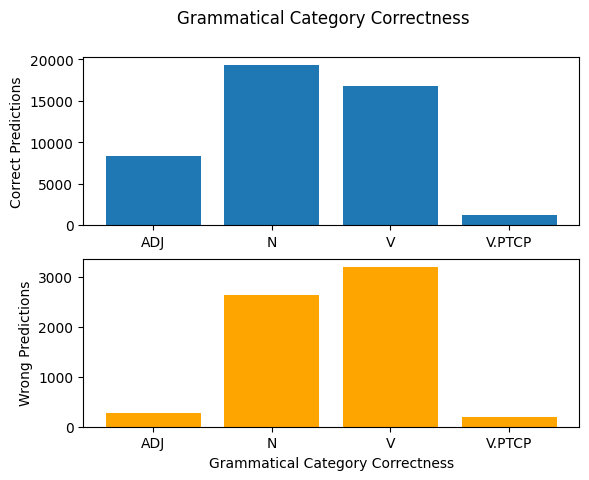

In [ ]:
plot_grammatical_category_correctness(results_deu_random)

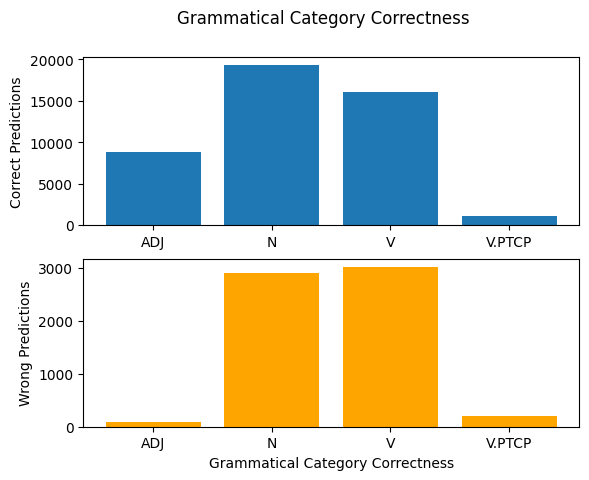

In [ ]:
plot_grammatical_category_correctness(results_deu_no_overlap)

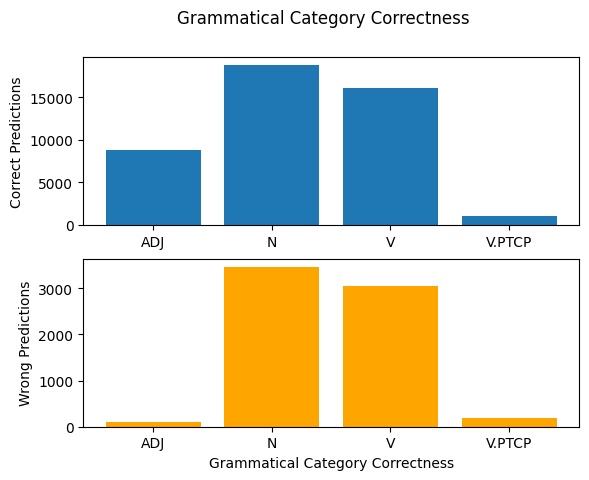

In [ ]:
plot_grammatical_category_correctness(results_deu_fake_copy)

* The `random` split is the one with less predictable capability when it comes to adjectives.
* The `random` split predicts better the nouns than the verbs, whereas the `fake_copy` one is the other way around. The `no_overlap` seems to have a similar competence with both Nouns and Verbs.
* Overall, all models seem to have a "linear" relationship with the accuracy and the amount of data. That is, the more data a category has, the more accurate predictions it will have. However, more errors we will have. In other words, the distributions are similar between correct and incorrect samples according to the size of each group.

Given that the accuracy is similar in all the datasets and we have not observed any significant difference in the distribution of errors or correct predictions, we will be taking a look at the `no_overlap` dataset results.

We will now analyze which specific morphological tags the model has performed best with. We will start with Nouns:

In [ ]:
results_N_deu_no_overlap = results_deu_no_overlap[results_deu_no_overlap.grammatical_category == 'N']
results_N_deu_no_overlap['case'] = results_N_deu_no_overlap.source_s.map(get_case)
results_N_deu_no_overlap['gender'] = results_N_deu_no_overlap.source_s.map(get_gender)
results_N_deu_no_overlap['number'] = results_N_deu_no_overlap.source_s.map(get_number)

<ipython-input-22-e156ec0a551a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_N_deu_no_overlap['case'] = results_N_deu_no_overlap.source_s.map(get_case)
<ipython-input-22-e156ec0a551a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_N_deu_no_overlap['gender'] = results_N_deu_no_overlap.source_s.map(get_gender)
<ipython-input-22-e156ec0a551a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

Each noun has a case:
* Nominative
* Accusative
* Dative
* Genitive

In [ ]:
results_N_deu_no_overlap.case.unique()

array(['NOM', 'ACC', 'DAT', 'GEN'], dtype=object)

Gener can be:
* Masculine
* Feminine
* Neutral
* Or any combination of the previous.

(*) You can see 'NA' as one of the genders. It wasn't specified in the data so we added this tag in the processing of the data.

In [ ]:
results_N_deu_no_overlap.gender.unique()

array(['NEUT', 'MASC', 'FEM', 'NA', 'MASC+FEM', 'MASC+NEUT', 'FEM+NEUT'],
      dtype=object)

Number can only be singular or plural:

In [ ]:
results_N_deu_no_overlap.number.unique()

array(['SG', 'PL'], dtype=object)

In [ ]:
contingency_table = pd.crosstab(results_N_deu_no_overlap.correct, [results_N_deu_no_overlap.case, results_N_deu_no_overlap.gender, results_N_deu_no_overlap.number])
contingency_table = contingency_table.T.reset_index()
contingency_table['total_samples'] = contingency_table[False] + contingency_table[True]
contingency_table['accuracy'] = contingency_table[True] / contingency_table['total_samples']
contingency_table = contingency_table.sort_values(by=['accuracy'], ascending=False)

In [ ]:
contingency_table[:10]

,a
0,1
1,2
2,3
,b
0,1
1,2
2,3


In [ ]:
contingency_table[-10:]

correct,case,gender,number,False,True,total_samples,accuracy
9,ACC,MASC+NEUT,SG,0,23,23,1.000000
3,ACC,FEM+NEUT,SG,0,4,4,1.000000
51,NOM,MASC+NEUT,SG,0,23,23,1.000000
17,DAT,FEM+NEUT,SG,0,4,4,1.000000
49,NOM,MASC+FEM,SG,0,14,14,1.000000
45,NOM,FEM+NEUT,SG,0,4,4,1.000000
20,DAT,MASC+FEM,PL,0,14,14,1.000000
11,ACC,NA,SG,1,208,209,0.995215
53,NOM,NA,SG,1,208,209,0.995215
47,NOM,MASC,SG,5,1033,1038,0.995183


## Conclusions, improvements and future work

* We have obtained a good accuracy in all models (almost 90%). However, as mentioned in the Catalan section, the `random` split results can be misleading, since we are training with information that appear later on the test set. This makes the model "remember" structures rather than infer them, thus the model is likely to not generalise well when facing an unseen sample.
* All three models have a similar distribution of errors and correct predictions, this is why some of our conclusions have been only analysed in the `no_overlap` model, which is the one providing better accuracy:
  * Our model struggles with irregular verbs or ortographical structures. Punctuation signs such as diaeresis or changes in the letter order when declining a word (re $↔$ er) make our model struggle.
  * A possible improvement (to be confirmed) could be training the model without casing, since in this data we include words starting with upper and lowercase, which can add complexity to the model. However, this would not imply a great improvement overall. This can be applied to any of the models (`random`, `no_overlap`, `fake_copy`).


# General Conclusions

* All models in both languages have taken less than 10 minutes each to train.
* Training a Neural Morphological Generator is easy when you have good data and does not require very big models.
* `random` split results can be misleading, since we are leaking test information during the training. This model is prone to "remember" rather than acutally infer, which is a more desirable behaviour when training a neural network.
* In terms of perfromance, there seems to be no big difference between `no_overlap` and `fake_copy` models.
* Catalan models have achieved an accuracy of 95%, higher than German models: either because of the simpler structure of the data (only verbs) or because the grammar is more regular. The Catalan dataset also had more balanced samples, which also helps.
* The German models still have proved to be quite good, with almost 90% accuracy.
* Both morphologies were quite different.
* Given the high performance it is hard to improve models more. However new improvements could be:
  * Removing casing in the German dataset.
  * Experimenting with the network size, to reduce resources and make the models lighter.
  * Create a new neural network with both datasets and make it bilingual.